# ガウス過程とt過程の比較
- トイデータを用いて、ガウス過程とt過程の簡単な比較を行った。
- データのわずかな変動により結果が大きく変わってしまうため、下記の結果にはあまり再現性はない。

# 0. Install
- (2019.05時点で)pipからGPyをインストールしようとすると、python3.7ではコケる。python3.6用の環境を別に用意したほうが良い。
- pipからinstallした場合、GPyのmodel.plot()が機能しないことがあった。
  - "conda install -c conda-forge gpy"を推奨。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import GPy

In [2]:
plt.style.use('ggplot')
np.random.seed(0) # この値によって結果が大きく変わる

# 1. Data

In [3]:
X = np.arange(-5,5,0.5)
truY = np.sin(X)
Y = truY + np.random.normal(loc=0, scale=0.1, size=X.shape[0])
X_new = np.arange(-7,7,0.05)

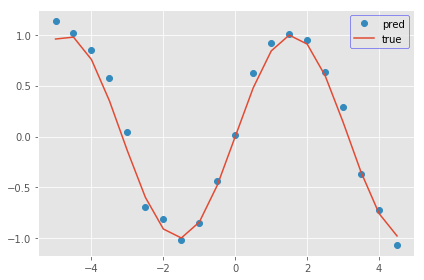

In [4]:
fig, ax = plt.subplots()
ax.plot(X, Y, color="C1", label="pred", marker="o", linestyle="")
ax.plot(X, truY, color="C0", label="true")
ax.legend(edgecolor="b")
fig.tight_layout()

# 2. Maternカーネルでの比較
## 2.1. hyperparameter推定前
- まずhyperparameter推定前の挙動を確認する。
  - ここで当てはまりが良ければ、hyperparameter推定がアバウトでも、ある程度の性能が期待できる？

Gaussian Process

 /anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


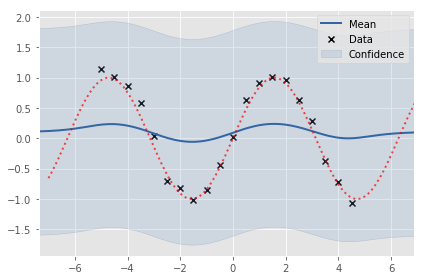

In [5]:
kern = GPy.kern.Matern52(input_dim=1, ARD=True)
gpmodel = GPy.models.GPRegression(X.reshape((-1,1)), Y.reshape((-1,1)), kernel=kern, normalizer=True)
gpmodel.randomize()
gpmodel.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

- mean functionはデータに沿っているが、分散は比較的大きい。  

Student-t Process

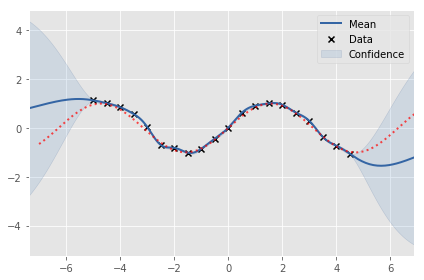

In [6]:
kern = GPy.kern.Matern52(input_dim=1, ARD=True)
tpmodel = GPy.models.TPRegression(X.reshape((-1,1)), Y.reshape((-1,1)), kernel=kern, normalizer=True)
tpmodel.randomize()
tpmodel.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

- hyperparameter推定前ながら、データのある領域においては分散も極めて小さい。
- ノイズにも完全にフィットしており、やや過学習傾向。

GPyのposterior_samples_fを用いたサンプリング結果の比較も示しておく。

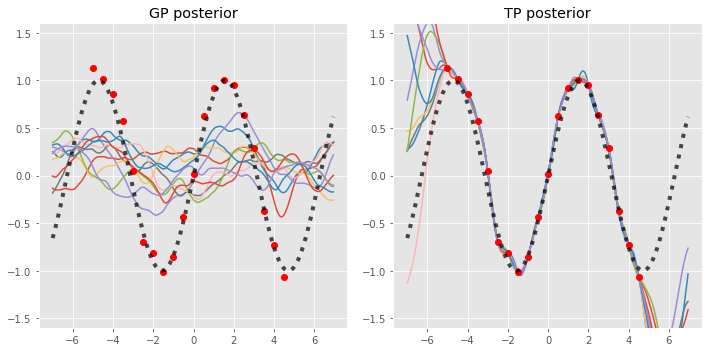

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X_new, gpmodel.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax1.plot(X, Y , marker="o", color="r", linestyle="")
ax1.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax1.set_title('GP posterior')
ax1.set_ylim([-1.6, 1.6])

ax2.plot(X_new, tpmodel.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax2.plot(X, Y , marker="o", color="r", linestyle="")
ax2.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax2.set_title('TP posterior')
ax2.set_ylim([-1.6, 1.6])
fig.tight_layout()

## 2.2 hyperparameter推定後

Gaussian Process

In [8]:
gpmodel.optimize()
gpmodel

GP_regression.,value,constraints,priors
Mat52.variance,2.454717048225763,+ve,
Mat52.lengthscale,2.709692408864183,+ve,
Gaussian_noise.variance,0.008594303144769645,+ve,


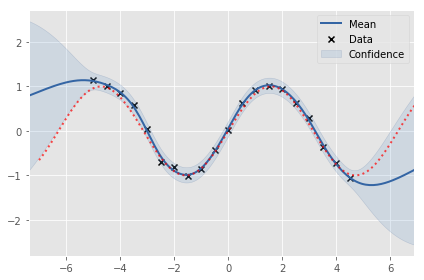

In [9]:
gpmodel.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

- データのある領域ではほぼフィットしている様子。
- 外挿は(当然ながら)当てにならない。

Student-t Process

In [10]:
tpmodel.optimize()
tpmodel

TP_regression.,value,constraints,priors
Mat52.variance,1.1340787279624882,+ve,
Mat52.lengthscale,1.359525674664267,+ve,
deg_free,73452.14557068727,+ve,


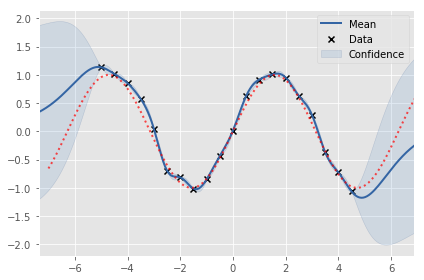

In [11]:
tpmodel.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

- かなり過学習傾向が見られる。
  - mean functionに加えて、分散も小さすぎる。
  - hyperparameterを点推定した弊害？

posterior_samples_fによる比較

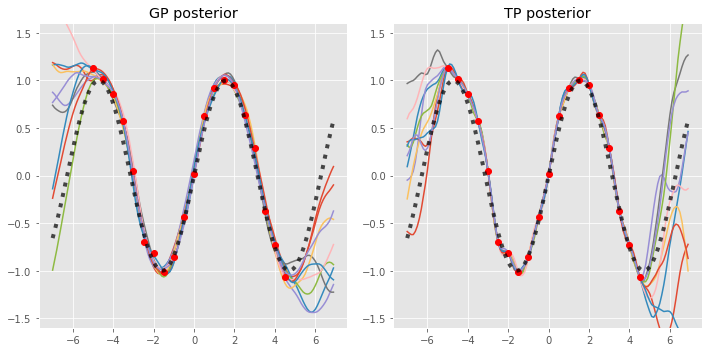

In [12]:
X_new = np.arange(-7,7,0.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X_new, gpmodel.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax1.plot(X, Y , marker="o", color="r", linestyle="")
ax1.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax1.set_title('GP posterior')
ax1.set_ylim([-1.6, 1.6])

ax2.plot(X_new, tpmodel.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax2.plot(X, Y , marker="o", color="r", linestyle="")
ax2.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax2.set_title('TP posterior')
ax2.set_ylim([-1.6, 1.6])
fig.tight_layout()

- 当てはまり自体に大きな差はないが、TPはデータの揺らぎに引っ張られ曲がっている箇所が散見される。
- (Maternカーネルにおいては、)TPがやや過学習傾向を見せ、採用しづらい結果となった。

# 3. MLPカーネル
- 滑らかな関数をフィッティングするため、MLPカーネル(aka. neural netカーネル)でも同様の計算を試行する。  

## 3.1. hyperparameter推定前

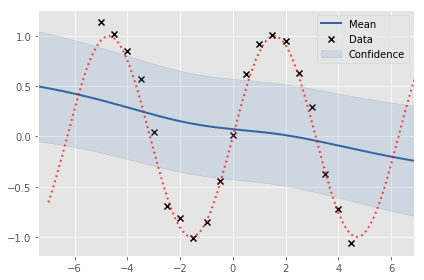

In [13]:
kern2 = GPy.kern.MLP(input_dim=1, ARD=True)
gpmodel2 = GPy.models.GPRegression(X.reshape((-1,1)), Y.reshape((-1,1)), kernel=kern2, normalizer=True)
gpmodel2.randomize()
gpmodel2.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

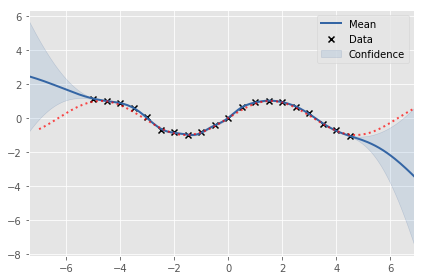

In [14]:
kern2 = GPy.kern.MLP(input_dim=1, ARD=True)
tpmodel2 = GPy.models.TPRegression(X.reshape((-1,1)), Y.reshape((-1,1)), kernel=kern2, normalizer=True)
tpmodel2.randomize()
tpmodel2.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

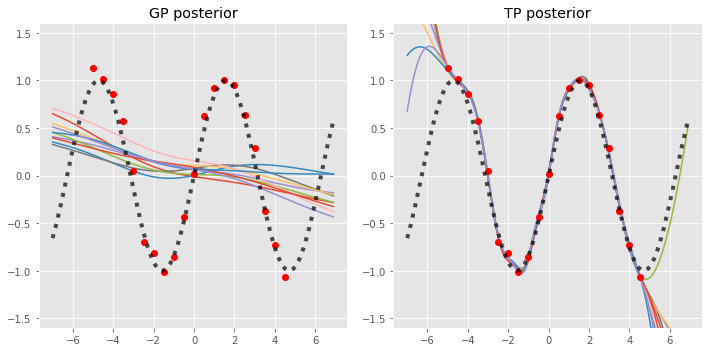

In [15]:
X_new = np.arange(-7,7,0.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X_new, gpmodel2.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax1.plot(X, Y , marker="o", color="r", linestyle="")
ax1.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax1.set_title('GP posterior')
ax1.set_ylim([-1.6, 1.6])

ax2.plot(X_new, tpmodel2.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax2.plot(X, Y , marker="o", color="r", linestyle="")
ax2.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax2.set_title('TP posterior')
ax2.set_ylim([-1.6, 1.6])
fig.tight_layout()

## 3.2. hyperparameter推定後

In [16]:
gpmodel2.optimize()
gpmodel2

GP_regression.,value,constraints,priors
mlp.variance,1058.3045681909434,+ve,
mlp.weight_variance,2.6517631057175344e-06,+ve,
mlp.bias_variance,4.692266943585428e-159,+ve,
Gaussian_noise.variance,0.9851204646058984,+ve,


In [17]:
tpmodel2.optimize()
tpmodel2

TP_regression.,value,constraints,priors
mlp.variance,0.017935063749283504,+ve,
mlp.weight_variance,0.03368667496553956,+ve,
mlp.bias_variance,4.35683430843654e-07,+ve,
deg_free,0.13228742432970403,+ve,


Gaussian Process

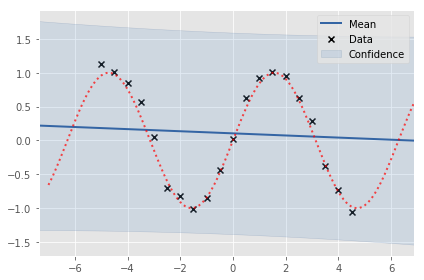

In [18]:
gpmodel2.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

Student-t Process

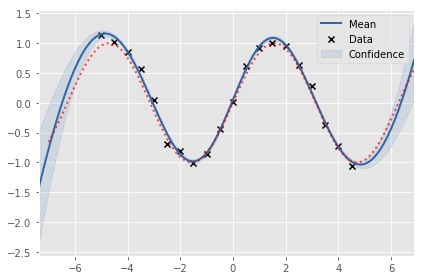

In [19]:
tpmodel2.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

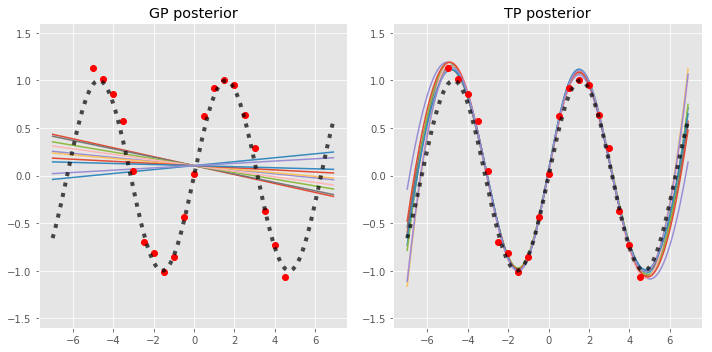

In [20]:
X_new = np.arange(-7,7,0.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X_new, gpmodel2.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax1.plot(X, Y , marker="o", color="r", linestyle="")
ax1.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax1.set_title('GP posterior')
ax1.set_ylim([-1.6, 1.6])

ax2.plot(X_new, tpmodel2.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax2.plot(X, Y , marker="o", color="r", linestyle="")
ax2.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax2.set_title('TP posterior')
ax2.set_ylim([-1.6, 1.6])
fig.tight_layout()

- TPは（運が良いと）外挿時もほぼsin形状を維持する。
- GPのMLEが機能していない。これはノイズorパラメータ分散の推定値が発散してしまったためと考えられる。

In [21]:
gpmodel2

GP_regression.,value,constraints,priors
mlp.variance,1058.3045681909434,+ve,
mlp.weight_variance,2.6517631057175344e-06,+ve,
mlp.bias_variance,4.692266943585428e-159,+ve,
Gaussian_noise.variance,0.9851204646058984,+ve,


- mlp.varianceが1000以上の値を取り、Gaussian_noise.varianceもデータに比して大きな値となっている。  

このような場合、いくつかの手段が考えうる。
- 実務上、Gaussian_noise.varianceなどに制限を加えることがある。
  - 統計的な妥当性が怪しい。直観的な設定を課すことは考えられるが、(当座の解析をこなす場合はともかく)解析者の関与しない自動化を目指す場合には取りづらい。
- Priorによる制約を加える。
  - この方法は魅力的だが、ここでは取らない。
- MCMCで置き換える。
  - 後に検討結果を示す。
- 再度randomizeし、optimizeをやり直す。
  - ここではこの方法を採用する。

 /anaconda3/envs/py36/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


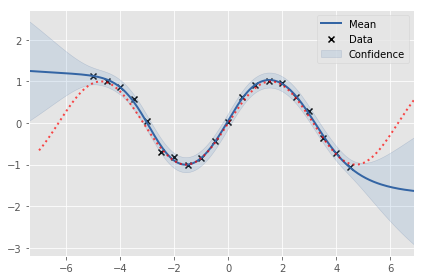

In [22]:
gpmodel2_save = gpmodel2.copy() #後の検討のためモデルを保存
gpmodel2.randomize()
gpmodel2.optimize()
gpmodel2.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

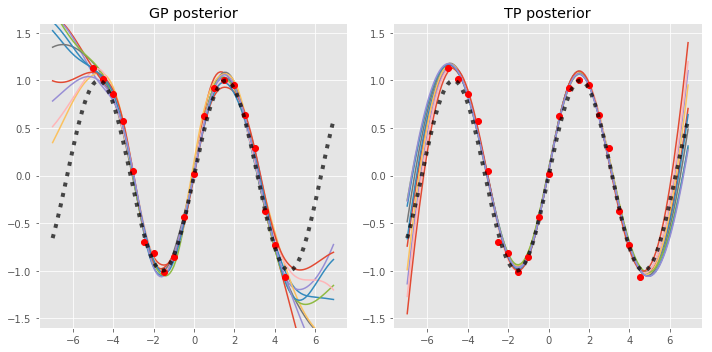

In [23]:
X_new = np.arange(-7,7,0.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X_new, gpmodel2.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax1.plot(X, Y , marker="o", color="r", linestyle="")
ax1.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax1.set_title('GP posterior')
ax1.set_ylim([-1.6, 1.6])

ax2.plot(X_new, tpmodel2.posterior_samples_f(X_new.reshape((-1,1)), size=10).reshape(-1,10))
ax2.plot(X, Y , marker="o", color="r", linestyle="")
ax2.plot(X_new, np.sin(X_new), color="k", linestyle="dotted", alpha=0.7, linewidth=4)
ax2.set_title('TP posterior')
ax2.set_ylim([-1.6, 1.6])
fig.tight_layout()

- GP側も落ち着いた。
- 当てはまりに大きな差は見られないが、TPは信頼区間が狭く、「真の曲線」が外に出てしまっている。

# 4. まとめ

1回動かしただけの感想であり、以下の記述には何の一般性も無いことに注意。
- GPに比べてTPはoptimize前からデータへの当てはまりが良く、hyperparameterへの依存は少ないと思しい。
- 反面TPの信頼区間は狭く、過学習しやすいのかもしれない。
  - 特に変動を想定するMaternカーネルとは(TP自体が急変動に対応するモデルのためか)相性が悪そう。
- MLPカーネルでの実験において、GPはoptimizeがうまくいかないことがあった。一方TPは頑健性を示した…のかもしれない?
- MLPカーネルではTPの外挿がうまくいったが、これは偶然の可能性が高い。

# Appendix. MCMC

- GPyは(一応)Metropolis法やHMCを実装しており、これを用いてhyperparameterを推定することもできる。
  - というより、一般にはHMCの使用が推奨されている(持橋先生&大羽先生のGP本など)。  
  
先ほどoptimizeに失敗したモデル(hyperparameter値ごと保存したもの)を用いて、これを修正できるか検討する。  
>optimize()を再度実行しても、このモデルは修正できない。すでに勾配を上りきっているため、初期化しなければoptimizeでは結果が変わらない。  
>本論での再実行は、randomizeを再実行し初期値を変更したためうまくいったものである。

In [24]:
gpmodel2_save

GP_regression.,value,constraints,priors
mlp.variance,1058.3045681909434,+ve,
mlp.weight_variance,2.6517631057175344e-06,+ve,
mlp.bias_variance,4.692266943585428e-159,+ve,
Gaussian_noise.variance,0.9851204646058984,+ve,


In [25]:
%%time
hmc = GPy.inference.mcmc.HMC(gpmodel2_save) # sampler
sample = hmc.sample()

CPU times: user 1min 14s, sys: 521 ms, total: 1min 14s
Wall time: 37.7 s


- iter=1000(デフォルト値)に1分以上を要しており、Stanの速度とは比べるべくもない。
- 注意点として、このHMCを動かすとgpmodelのparametersは変動する。以前の値と比較したい場合は別途copyしておくべし。

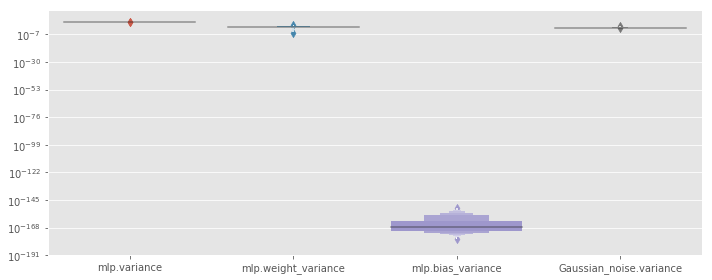

In [26]:
import seaborn as sns
param_name = gpmodel2_save.parameter_names()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')
sns.boxenplot(data=sample, ax=ax)
ax.set_xticklabels(param_name)
fig.tight_layout()

- sampling結果を図示した…が桁が違いすぎてよくわからなくなってしまった。

元のモデルに(hyperparameterの)EAP推定量を代入し、結果を確認する。

 /anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


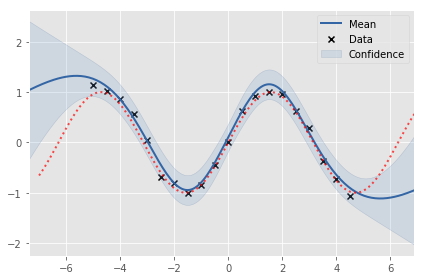

In [27]:
for ii in range(len(param_name)):
    gpmodel2_save[param_name[ii]] = np.mean(sample, axis=0)[ii]
gpmodel2_save.plot()
plt.plot(X_new, np.sin(X_new), color="r", linestyle="dotted", alpha=0.7, linewidth=2)
plt.tight_layout()

- MCMCにより修正された！

In [28]:
gpmodel2_save

GP_regression.,value,constraints,priors
mlp.variance,1101.2029607358568,+ve,
mlp.weight_variance,0.17356309585415938,+ve,
mlp.bias_variance,1.2953297967270649e-154,+ve,
Gaussian_noise.variance,0.03295987389854089,+ve,


- Gaussian_noise.varianceがかなり小さくなってくれた。